In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl


import sys
sys.path.append('../Utilities/')

from tqdm.notebook import tqdm

import importlib
import data_utils
importlib.reload(data_utils)

## Import MDS from sklearn
from sklearn.manifold import MDS
from sklearn.metrics import accuracy_score, f1_score
mds = MDS(n_components=1, random_state=0, normalized_stress='auto')

In [2]:
class SelfAttention(nn.Module):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels
        
        self.query_conv = nn.Conv1d(channels, channels // 8, kernel_size=1, bias=False)
        self.key_conv = nn.Conv1d(channels, channels // 8, kernel_size=1, bias=False)
        self.value_conv = nn.Conv1d(channels, channels, kernel_size=1, bias=False)
        
    def forward(self, x):
        batch_size, channels, seq_len = x.size()  # Get batch size, channels, and sequence length
        
        query = self.query_conv(x)
        key = self.key_conv(x)
        value = self.value_conv(x)
        
        # Reshape query, key, and value tensors for matrix multiplication
        query = query.view(batch_size, -1, seq_len)
        key = key.view(batch_size, -1, seq_len)
        
        attn_scores = F.softmax(torch.bmm(query.transpose(1, 2), key), dim=-1)
        attended = torch.bmm(attn_scores, value.transpose(1, 2)).transpose(1, 2)
        
        return attended

In [3]:
class UNet1D_Attn(nn.Module):
    def __init__(self, in_channels, out_channels, depth=2, num_layers=2):
        super(UNet1D_Attn, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_layers = num_layers
        self.depth = depth
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.num_start_filters = 32

        self._create_unet(self.in_channels, self.num_start_filters)

        self.encoder_output_shape = int(np.floor(300/(2**depth)))
        self.encoder_feature_maps = int(self.num_start_filters * 2 ** (self.depth - 1))

        self.bottleneck = nn.Sequential(
            nn.Conv1d(self.encoder_feature_maps, 2 * self.encoder_feature_maps, kernel_size=1, padding=0),
            nn.ReLU()
        )

        self.logits = nn.Conv1d(self.num_start_filters, self.out_channels, 1, 1)

    def _create_encoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2),
            nn.ReLU(),
            SelfAttention(out_channels)
        )

    def _create_decoder_block(self, in_channels, out_channels):
        return nn.ModuleList(
            [nn.ConvTranspose1d(in_channels, in_channels//2, kernel_size=2, stride=2),
            nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2),
            SelfAttention(out_channels),
            nn.ReLU()])

    def _create_unet(self, in_channels, out_channels):
        for _ in range(self.depth):
            self.encoder.append(self._create_encoder_block(in_channels, out_channels))
            in_channels, out_channels = out_channels, out_channels*2

        out_channels = in_channels
        in_channels = in_channels * 2
        for _ in range(self.depth):
            self.decoder.append(self._create_decoder_block(in_channels, out_channels))
            in_channels, out_channels = out_channels, out_channels//2

    def forward(self, x):
        encoded = []
        for enc in self.encoder:
            x = enc(x)
            encoded.append(x)
            x = nn.MaxPool1d(kernel_size=2, stride=2)(x)
            
        x = self.bottleneck(x)  # Bottleneck layer
        # x = torch.reshape(x, (-1, self.encoder_feature_maps*2, self.encoder_output_shape))


        for dec in self.decoder:
            ## Adding input with encoder concatenation
            enc_output = encoded.pop()
            x = dec[0](x)
            ## Pad the decoder output to match the encoder output
            diff = enc_output.shape[2] - x.shape[2]
            x = F.pad(x, (diff // 2, diff - diff // 2))
            x = torch.cat((enc_output, x), dim=1)
            x = dec[1](x)
            x = dec[2](x)
        ## Add softmax to logits
        # x = self.softmax(x)

        return self.logits(x)

input_channels = 6 
output_channels = 1
depth = 3
num_layers = 2

model = UNet1D_Attn(input_channels, output_channels, depth, num_layers)
# print(model)

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [53]:
# Generate synthetic data
num_superpixels = 300
num_features = 6
synthetic_data = np.random.rand(num_superpixels, num_features)
synthetic_data = torch.tensor(synthetic_data, dtype=torch.float32)

#Reshape
synthetic_data = synthetic_data.unsqueeze(0).transpose(1, 2)

# Pass the synthetic data through the U-Net model
with torch.no_grad():
    output = model(synthetic_data)

print("Input shape:", synthetic_data.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([1, 6, 300])
Output shape: torch.Size([1, 1, 300])


### Creating LightningModule 

In [54]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = dice_loss + BCE
        
        return Dice_BCE

In [55]:
class CloudSegmentationModel(pl.LightningModule):
    def __init__(self, depth=2):
        super(CloudSegmentationModel, self).__init__()
        self.unet = UNet1D_Attn(in_channels=6, out_channels=1, depth=depth)
        
    def forward(self, x):
        return nn.Sigmoid()(self.unet(x))

    def accuracy_score(self, y_true, y_pred):
        y_true = y_true.cpu().detach().numpy()
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = np.where(y_pred > 0.5, 1, 0)
        return accuracy_score(y_true, y_pred)

    def training_step(self, batch, batch_idx):
        superpixel, label = batch
        output = self(superpixel)
        loss = nn.BCELoss()(output, label)

        # Calculate accuracy
        predicted = torch.round(output)
        correct = (predicted == label).sum().item()
        total = label.size(0) * label.size(1) * label.size(2)
        accuracy = correct / total

        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_accuracy', accuracy, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        superpixel, label = batch
        output = self(superpixel)
        loss = nn.BCELoss()(output, label)

        # Calculate accuracy
        predicted = torch.round(output)
        correct = (predicted == label).sum().item()
        total = label.size(0) * label.size(1) * label.size(2)
        accuracy = correct / total

        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_accuracy', accuracy, on_step=False, on_epoch=True)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [56]:
model = CloudSegmentationModel()
print("Parameters: ",count_parameters(model))

with torch.no_grad():
    output = model(synthetic_data)

print("Input shape:", synthetic_data.shape)
print("Output shape:", output.shape)

Parameters:  104321
Input shape: torch.Size([1, 6, 300])
Output shape: torch.Size([1, 1, 300])


### Creating Dataset

In [57]:
patches,mask = data_utils.get_patch(path_to_folders_images = "../Dataset/Natural_False_Color/", path_to_folders_labels = "../Dataset/Entire_scene_gts/")

c:\Users\GP65\anaconda3\lib\site-packages\rasterio\__init__.py:333: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [58]:
# X = []
# y = []
# raw = []
# slic_map = []
# original_ordering = []

# for i,j in tqdm(list(zip(patches,mask))):
#     # try:
#     segmented_image_rgb, properties, labels, segmented_binary_array, segments = data_utils.convert_image_array_to_slic_with_properties(i,j,n_segments=300) 

#     ## Getting the X and y arrays
#     raw.append(segmented_image_rgb)
#     slic_map.append(segments)
#     X_array = np.array([list(list(i.values())[1]) + list(i.values())[2:-1] for i in properties])
#     y_array = np.array(labels)

#     ## Normalizing the X_array columwise
#     X_array[:,0] = X_array[:,0]/255
#     X_array[:,1] = X_array[:,1]/255
#     X_array[:,2] = X_array[:,2]/255
#     X_array[:,3] = X_array[:,3]/512
#     X_array[:,4] = X_array[:,4]/512
#     X_array[:,5] = X_array[:,5]/1000

#     ## Ordering
#     ordering = mds.fit_transform(X_array[:,3:5]).reshape(-1)
#     original_ordering.append(ordering.argsort())
#     X_array = X_array[ordering.argsort()]
#     y_array = y_array[ordering.argsort()]


#     ## Pad the X_array with -1 and y_array with 0 upto 300
#     X_array = np.pad(X_array,((0,300-X_array.shape[0]),(0,0)),mode='constant',constant_values=-1)
#     y_array = np.pad(y_array,(0,300-y_array.shape[0]),mode='constant',constant_values=0).reshape(-1,1)


#     ## Appending
#     X.append(X_array)
#     y.append(y_array)
    
#     # except KeyboardInterrupt:
#     #     break
#     # except:
#     #     pass

In [59]:
def unpad_and_plot(X,y,original_ordering,slic_map):
    label = y[[X[:,0] != -1]]
    label = label[original_ordering.argsort()]
    plt.imshow(data_utils.reverse_segmentation(slic_map,label))
    plt.show()

def unpad_and_map(X,y,original_ordering,slic_map):
    label = y[[X[:,0] != -1]]
    label = label[original_ordering.argsort()]
    map = data_utils.reverse_segmentation(slic_map,label)
    return map

In [60]:
# np.save('../Dataset/X.npy', np.array(X))
# np.save('../Dataset/Y.npy', np.array(y))
# np.save('../Dataset/raw.npy', np.array(raw))
# np.save('../Dataset/slic_map.npy', np.array(slic_map))
# np.save('../Dataset/original_ordering.npy', np.array(original_ordering))


X = np.load('../Dataset/X.npy')
y = np.load('../Dataset/Y.npy')
raw = np.load('../Dataset/raw.npy')
slic_map = np.load('../Dataset/slic_map.npy')
original_ordering = np.load('../Dataset/original_ordering.npy', allow_pickle=True)

In [61]:
# ##plot segmented_image_rgb
# plt.imshow(raw[16])
# plt.show()
# unpad_and_plot(X[16],y[16],original_ordering[16],slic_map[16])

In [62]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_item = torch.tensor(self.X[idx], dtype=torch.float32).T
        y_item = torch.tensor(self.y[idx], dtype=torch.float32).T
        return x_item, y_item

def create_dataloader(X, y, batch_size=32, shuffle=True):
    dataset = CustomDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [63]:
## Divide X and Y into train and test sets
np.random.seed(42)
test_index = np.random.choice(range(len(X)), size=200, replace=False)
train_index = [i for i in range(len(X)) if i not in test_index]

X_train = X[train_index]
X_test = X[test_index]
y_train = y[train_index]
y_test = y[test_index]

In [64]:
train_loader = create_dataloader(X_train,y_train,batch_size=64,shuffle=True)
test_loader = create_dataloader(X_test,y_test,batch_size=64,shuffle=True)

## Training with PL

In [66]:
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger

In [72]:
# Initialize the model and trainer
segmentationModel = CloudSegmentationModel(depth=3)

In [73]:
logger = TensorBoardLogger('lightning_logs/', name='sgd_tagger_ann')

In [74]:
checkpoint_callback = ModelCheckpoint(
    dirpath = './attn_model_checkpt/',
    filename = 'best-checkpoint',
    save_top_k=1,
    verbose = True,
    monitor='val_loss',
    mode='min'
)

In [75]:
trainer = Trainer(
    logger = logger,
    gpus=1 if torch.cuda.is_available() else None,
    max_epochs=1000,
    callbacks=[EarlyStopping(monitor='val_loss', patience=20), checkpoint_callback]
)

# Train the model using the trainer
trainer.fit(segmentationModel, train_loader, test_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type        | Params
-------------------------------------
0 | unet | UNet1D_Attn | 440 K 
-------------------------------------
440 K     Trainable params
0         Non-trainable params
440 K     Total params
1.763     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 24/24 [00:00<00:00, 25.44it/s, loss=0.687, v_num=9]

Epoch 0, global step 20: 'val_loss' reached 0.64196 (best 0.64196), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v9.ckpt' as top 1


Epoch 1: 100%|██████████| 24/24 [00:00<00:00, 30.99it/s, loss=0.628, v_num=9]

Epoch 1, global step 40: 'val_loss' reached 0.63387 (best 0.63387), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v9.ckpt' as top 1


Epoch 2: 100%|██████████| 24/24 [00:00<00:00, 31.85it/s, loss=0.631, v_num=9]

Epoch 2, global step 60: 'val_loss' reached 0.62898 (best 0.62898), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v9.ckpt' as top 1


Epoch 3: 100%|██████████| 24/24 [00:00<00:00, 32.90it/s, loss=0.622, v_num=9]

Epoch 3, global step 80: 'val_loss' reached 0.61743 (best 0.61743), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v9.ckpt' as top 1


Epoch 4: 100%|██████████| 24/24 [00:00<00:00, 33.69it/s, loss=0.594, v_num=9]

Epoch 4, global step 100: 'val_loss' reached 0.57164 (best 0.57164), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v9.ckpt' as top 1


Epoch 5: 100%|██████████| 24/24 [00:00<00:00, 32.48it/s, loss=0.555, v_num=9]

Epoch 5, global step 120: 'val_loss' reached 0.53188 (best 0.53188), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v9.ckpt' as top 1


Epoch 6: 100%|██████████| 24/24 [00:00<00:00, 30.81it/s, loss=0.524, v_num=9]

Epoch 6, global step 140: 'val_loss' reached 0.49269 (best 0.49269), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v9.ckpt' as top 1


Epoch 7: 100%|██████████| 24/24 [00:00<00:00, 33.83it/s, loss=0.516, v_num=9]

Epoch 7, global step 160: 'val_loss' was not in top 1


Epoch 8: 100%|██████████| 24/24 [00:00<00:00, 32.17it/s, loss=0.495, v_num=9]

Epoch 8, global step 180: 'val_loss' reached 0.47065 (best 0.47065), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v9.ckpt' as top 1


Epoch 9: 100%|██████████| 24/24 [00:00<00:00, 31.60it/s, loss=0.47, v_num=9] 

Epoch 9, global step 200: 'val_loss' reached 0.45572 (best 0.45572), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v9.ckpt' as top 1


Epoch 10: 100%|██████████| 24/24 [00:00<00:00, 33.71it/s, loss=0.457, v_num=9]

Epoch 10, global step 220: 'val_loss' reached 0.44326 (best 0.44326), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v9.ckpt' as top 1


Epoch 11: 100%|██████████| 24/24 [00:00<00:00, 32.72it/s, loss=0.439, v_num=9]

Epoch 11, global step 240: 'val_loss' reached 0.43378 (best 0.43378), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v9.ckpt' as top 1


Epoch 12: 100%|██████████| 24/24 [00:00<00:00, 30.19it/s, loss=0.439, v_num=9]

Epoch 12, global step 260: 'val_loss' was not in top 1


Epoch 13: 100%|██████████| 24/24 [00:00<00:00, 32.43it/s, loss=0.439, v_num=9]

Epoch 13, global step 280: 'val_loss' reached 0.42926 (best 0.42926), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v9.ckpt' as top 1


Epoch 14: 100%|██████████| 24/24 [00:00<00:00, 32.67it/s, loss=0.446, v_num=9]

Epoch 14, global step 300: 'val_loss' was not in top 1


Epoch 15: 100%|██████████| 24/24 [00:00<00:00, 30.77it/s, loss=0.449, v_num=9]

Epoch 15, global step 320: 'val_loss' was not in top 1


Epoch 16: 100%|██████████| 24/24 [00:00<00:00, 32.06it/s, loss=0.44, v_num=9] 

Epoch 16, global step 340: 'val_loss' was not in top 1


Epoch 17: 100%|██████████| 24/24 [00:00<00:00, 34.43it/s, loss=0.434, v_num=9]

Epoch 17, global step 360: 'val_loss' was not in top 1


Epoch 18: 100%|██████████| 24/24 [00:00<00:00, 31.41it/s, loss=0.434, v_num=9]

Epoch 18, global step 380: 'val_loss' was not in top 1


Epoch 19: 100%|██████████| 24/24 [00:00<00:00, 31.70it/s, loss=0.439, v_num=9]

Epoch 19, global step 400: 'val_loss' was not in top 1


Epoch 20: 100%|██████████| 24/24 [00:00<00:00, 30.04it/s, loss=0.432, v_num=9]

Epoch 20, global step 420: 'val_loss' was not in top 1


Epoch 21: 100%|██████████| 24/24 [00:00<00:00, 31.02it/s, loss=0.43, v_num=9] 

Epoch 21, global step 440: 'val_loss' reached 0.42819 (best 0.42819), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v9.ckpt' as top 1


Epoch 22: 100%|██████████| 24/24 [00:00<00:00, 32.74it/s, loss=0.433, v_num=9]

Epoch 22, global step 460: 'val_loss' was not in top 1


Epoch 23: 100%|██████████| 24/24 [00:00<00:00, 33.47it/s, loss=0.435, v_num=9]

Epoch 23, global step 480: 'val_loss' was not in top 1


Epoch 24: 100%|██████████| 24/24 [00:00<00:00, 31.17it/s, loss=0.434, v_num=9]

Epoch 24, global step 500: 'val_loss' was not in top 1


Epoch 25: 100%|██████████| 24/24 [00:00<00:00, 31.95it/s, loss=0.431, v_num=9]

Epoch 25, global step 520: 'val_loss' reached 0.42741 (best 0.42741), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v9.ckpt' as top 1


Epoch 26: 100%|██████████| 24/24 [00:00<00:00, 33.57it/s, loss=0.429, v_num=9]

Epoch 26, global step 540: 'val_loss' was not in top 1


Epoch 27: 100%|██████████| 24/24 [00:00<00:00, 29.86it/s, loss=0.434, v_num=9]

Epoch 27, global step 560: 'val_loss' was not in top 1


Epoch 28: 100%|██████████| 24/24 [00:00<00:00, 32.32it/s, loss=0.432, v_num=9]

Epoch 28, global step 580: 'val_loss' was not in top 1


Epoch 29: 100%|██████████| 24/24 [00:00<00:00, 33.44it/s, loss=0.44, v_num=9] 

Epoch 29, global step 600: 'val_loss' was not in top 1


Epoch 30: 100%|██████████| 24/24 [00:00<00:00, 29.99it/s, loss=0.436, v_num=9]

Epoch 30, global step 620: 'val_loss' was not in top 1


Epoch 31: 100%|██████████| 24/24 [00:00<00:00, 31.04it/s, loss=0.436, v_num=9]

Epoch 31, global step 640: 'val_loss' was not in top 1


Epoch 32: 100%|██████████| 24/24 [00:00<00:00, 33.94it/s, loss=0.436, v_num=9]

Epoch 32, global step 660: 'val_loss' was not in top 1


Epoch 33: 100%|██████████| 24/24 [00:00<00:00, 30.47it/s, loss=0.434, v_num=9]

Epoch 33, global step 680: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 24/24 [00:00<00:00, 30.04it/s, loss=0.437, v_num=9]

Epoch 34, global step 700: 'val_loss' was not in top 1


Epoch 35: 100%|██████████| 24/24 [00:00<00:00, 32.69it/s, loss=0.43, v_num=9] 

Epoch 35, global step 720: 'val_loss' reached 0.42558 (best 0.42558), saving model to 'D:\\Projects\\ComputerVision_CloudSegmentation\\Superpixel-UNET\\model_checkpt\\best-checkpoint-v9.ckpt' as top 1


Epoch 36: 100%|██████████| 24/24 [00:00<00:00, 33.06it/s, loss=0.433, v_num=9]

Epoch 36, global step 740: 'val_loss' was not in top 1


Epoch 37: 100%|██████████| 24/24 [00:00<00:00, 31.54it/s, loss=0.429, v_num=9]

Epoch 37, global step 760: 'val_loss' was not in top 1


Epoch 38: 100%|██████████| 24/24 [00:00<00:00, 32.62it/s, loss=0.431, v_num=9]

Epoch 38, global step 780: 'val_loss' was not in top 1


Epoch 39: 100%|██████████| 24/24 [00:00<00:00, 34.53it/s, loss=0.432, v_num=9]

Epoch 39, global step 800: 'val_loss' was not in top 1


Epoch 40: 100%|██████████| 24/24 [00:00<00:00, 29.17it/s, loss=0.432, v_num=9]

Epoch 40, global step 820: 'val_loss' was not in top 1


Epoch 41: 100%|██████████| 24/24 [00:00<00:00, 29.85it/s, loss=0.426, v_num=9]

Epoch 41, global step 840: 'val_loss' was not in top 1


Epoch 42: 100%|██████████| 24/24 [00:00<00:00, 34.38it/s, loss=0.427, v_num=9]

Epoch 42, global step 860: 'val_loss' was not in top 1


Epoch 43: 100%|██████████| 24/24 [00:00<00:00, 30.82it/s, loss=0.427, v_num=9]

Epoch 43, global step 880: 'val_loss' was not in top 1


Epoch 44: 100%|██████████| 24/24 [00:00<00:00, 32.21it/s, loss=0.428, v_num=9]

Epoch 44, global step 900: 'val_loss' was not in top 1


Epoch 45: 100%|██████████| 24/24 [00:00<00:00, 33.79it/s, loss=0.431, v_num=9]

Epoch 45, global step 920: 'val_loss' was not in top 1


Epoch 46: 100%|██████████| 24/24 [00:00<00:00, 31.65it/s, loss=0.43, v_num=9] 

Epoch 46, global step 940: 'val_loss' was not in top 1


Epoch 47: 100%|██████████| 24/24 [00:00<00:00, 32.25it/s, loss=0.431, v_num=9]

Epoch 47, global step 960: 'val_loss' was not in top 1


Epoch 48: 100%|██████████| 24/24 [00:00<00:00, 33.45it/s, loss=0.434, v_num=9]

Epoch 48, global step 980: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 24/24 [00:00<00:00, 27.75it/s, loss=0.428, v_num=9]

Epoch 49, global step 1000: 'val_loss' was not in top 1


Epoch 50: 100%|██████████| 24/24 [00:00<00:00, 30.28it/s, loss=0.427, v_num=9]

Epoch 50, global step 1020: 'val_loss' was not in top 1


Epoch 51: 100%|██████████| 24/24 [00:00<00:00, 31.85it/s, loss=0.425, v_num=9]

Epoch 51, global step 1040: 'val_loss' was not in top 1


Epoch 52: 100%|██████████| 24/24 [00:00<00:00, 26.19it/s, loss=0.425, v_num=9]

Epoch 52, global step 1060: 'val_loss' was not in top 1


Epoch 53: 100%|██████████| 24/24 [00:00<00:00, 28.07it/s, loss=0.429, v_num=9]

Epoch 53, global step 1080: 'val_loss' was not in top 1


Epoch 54: 100%|██████████| 24/24 [00:00<00:00, 32.21it/s, loss=0.423, v_num=9]

Epoch 54, global step 1100: 'val_loss' was not in top 1


Epoch 55: 100%|██████████| 24/24 [00:00<00:00, 33.17it/s, loss=0.424, v_num=9]

Epoch 55, global step 1120: 'val_loss' was not in top 1


Epoch 55: 100%|██████████| 24/24 [00:00<00:00, 32.86it/s, loss=0.424, v_num=9]


## Manual Model test

<ipython-input-59-e9d455cf8280>:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  label = y[[X[:,0] != -1]]


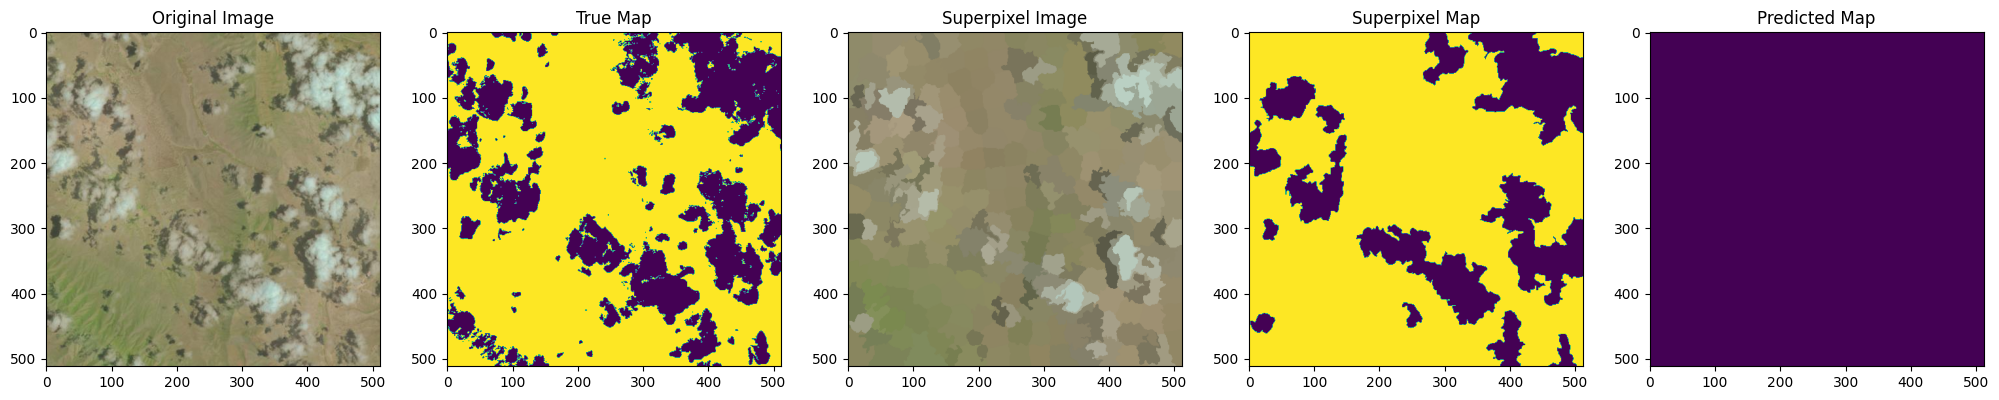

In [76]:
##plot segmented_image_rgb
i = 466

y_true = unpad_and_map(X[i],y[i],original_ordering[i],slic_map[i])
y_pred = np.round(segmentationModel(torch.tensor([X[i].T], dtype=torch.float32)).detach().numpy().reshape(-1))
y_pred = unpad_and_map(X[i],y_pred,original_ordering[i],slic_map[i])
## Make a 1x3 subplot
fig, ax = plt.subplots(1, 5, figsize=(25, 10))

## Plot the original image
ax[0].imshow(patches[i])
ax[0].set_title('Original Image')

## Plot the true segmentation
ax[1].imshow(mask[i])
ax[1].set_title('True Map')

## Plot the superpixel segmentation
ax[2].imshow(raw[i])
ax[2].set_title('Superpixel Image')

## Plot the true segmentation
ax[3].imshow(y_true)
ax[3].set_title('Superpixel Map')

## Plot the predicted segmentation
ax[4].imshow(y_pred)
ax[4].set_title('Predicted Map')

## Show the plot
plt.show()

### Calculate DICE

In [514]:
## Write a function to calculate the dice score between two images
def get_jaccard_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    jaccard = np.sum(intersection) / np.sum(union)
    return jaccard

def get_dice_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    dice = 2 * np.sum(intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice


In [515]:
pred_maps = []
for i in tqdm(test_index):
    y_pred = np.round(segmentationModel(torch.tensor([X[i].T], dtype=torch.float32)).detach().numpy().reshape(-1))
    pred = unpad_and_map(X[i],y_pred,original_ordering[i],slic_map[i])
    pred_maps.append(pred)

dice = []
for i,j in tqdm(zip(np.array(pred_maps),mask[test_index])):
    dice.append(get_dice_score(i,j))

jaccard = []
for i,j in tqdm(zip(np.array(pred_maps),mask[test_index])):
    jaccard.append(get_jaccard_score(i,j))

  0%|          | 0/200 [00:00<?, ?it/s]

<ipython-input-434-e9d455cf8280>:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  label = y[[X[:,0] != -1]]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [516]:
print("Overall Dice:", np.mean(dice))
print("Overall Jaccard:", np.mean(jaccard))

Overall Dice: 0.8024769273073467
Overall Jaccard: 0.7165479934353844
